<span style="font-family:Lucida Bright;">

<hr style="border:2px solid black"> </hr>

<p style="margin-bottom:1cm"></p>

<center>
<font size="7"><b>Social Data Analysis and Visualization</b></font>
<p style="margin-bottom:1cm"></p>
<font size="6.8"><b>Final Project</b></font>   
<p style="margin-bottom:0.8cm"></p>
<font size="3"><b>Wojciech Mazurkiewicz, DTU, 14 May 2021</b></font>
<br>
<font size="3"><b></b></font>

</center>

<p style="margin-bottom:0.7cm"></p>

<hr style="border:2px solid black"> </hr>

<hr style="border:2px solid black"> </hr>

<span style="font-family:Lucida Bright;">

# Initialization

## How to read this notebook

In this notebook, the questions are either specified in the section title, or marked with

> __bold quote__

The answers are marked with <span style="font-family:Lucida Bright;">*Lucida Bright italics*</span>.

Please note that the pre-rendered outputs will first display properly when the notebook is __trusted__.
    
</span>

## Imports

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy import stats
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
from matplotlib.image import NonUniformImage
from matplotlib.colors import Normalize
from IPython.display import YouTubeVideo
from IPython.display import Markdown
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
from folium.plugins import HeatMap, HeatMapWithTime
from folium.map import FeatureGroup
from bokeh.models.sources import ColumnDataSource
from bokeh.models.ranges import FactorRange
from bokeh.models import Legend
from bokeh.io import show
from bokeh.io import output_notebook
from bokeh.io import output_file
import urllib.request
import seaborn as sns
import scipy.stats
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import folium
import datetime
import calendar
import bokeh.plotting as bplt
%matplotlib inline

##  Configuration

In [2]:
# Show bokeh figures in the notebook.
output_notebook()

# Below decide which output is shown below the cells.
InteractiveShell.ast_node_interactivity = "none"

# Decide how to handle the "SettingWithCopyWarning" warning
pd.options.mode.chained_assignment = None  # default='warn'

# Set the maximum number of rows to show when displaying
# a Pandas dataframe.
pd.options.display.max_rows = 150

Loading BokehJS ...

## Function definitions

### Plotting functions

In [53]:
# A function that applies default formatting to an axes.
def format_axes(axes: plt.Axes,
                keep_box=False):
    if not keep_box:
        axes.spines['top'].set_color('white')
        axes.spines['right'].set_color('white')

    axes.set_facecolor("white")


# A function that applies default formatting to annotation
# of an axes.
def format_axes_annotation(axes: plt.Axes):
    axes.xaxis.label.set_fontsize(14)
    axes.yaxis.label.set_fontsize(14)
    axes.title.set_fontsize(16)


# A function for creating common x-label for the figure.
def figure_x_label(figure: plt.Figure,
                   label: str,
                   y_position=0.04,
                   font_size=16):
    figure.text(0.5, y_position, label,
                ha='center',
                fontdict={'size': font_size})


# A function for creating common y-label for the figure.
def figure_y_label(figure: plt.Figure,
                   label: str,
                   x_position=0.04,
                   font_size=16):
    figure.text(x_position, 0.5, label,
                va='center',
                rotation='vertical',
                fontdict={'size': font_size})


# A function that draws a horizontal line across the entire axes.
def draw_threshold(value: float,
                   axes: plt.Axes,
                   linewidth=1,
                   linestyle='-',
                   color=None,
                   title=None):
    
    # Get axes limits and ranges.
    x_min, x_max = axes.get_xlim()
    x_range = x_max - x_min
    y_min, y_max = axes.get_ylim()
    y_range = y_max - y_min
    
    # Plot the threshold line.
    axes.plot([x_min, x_max], [value, value],
              linewidth=1,
              linestyle='-',
              color=color)
    
    # Write a title above the threshold line
    if title is not None:
        axes.text(x_min + 0.01 * x_range,
                  value + 0.02 * y_range,
                  title)

###  Dataframe functions

In [4]:
# A function for balancing a dataframe so that the number of rows
# containing each value present in the designated column will be the same.
def balance_dataframe(df: pd.DataFrame, column_name):
    # Get the number of crimes for the least frequent crime.
    lowest_frequency = df['Category'].value_counts().min()

    # Create an empty dataframe for storing the balanced data
    df_balanced = pd.DataFrame()

    # For each value in column, randomly choose the number of samples
    # that corresponds to the least frequent value in the column.
    for value in df[column_name].unique():
        df_balanced = df_balanced.append(
            df
            .loc[df[column_name] == value]
            .sample(lowest_frequency)
        )

    return df_balanced


# A function that evaluates a dictionary of models on data from
# a pandas dataframe.
def evaluate_models(models: dict,
                    df: pd.DataFrame,
                    predictor_labels: list,
                    target_label: str,
                    test_size=0.33):

    # Get the dataset.
    X = df.loc[:, predictor_labels].values
    y = df.loc[:, target_label].values

    # Split the dataset into a test and training set.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=32)

    # Fit the models to the data.
    for model_name, model in models.items():

        # Print the name of the model.
        printmd(f'*__{model_name}:__*')

        # Train the model on the training set.
        model.fit(X_train, y_train)

        # Get the predictions on the test set.
        predictions = model.predict(X_test)

        # Print the classification report.
        print(classification_report(y_test, predictions,
                                    zero_division=0,
                                    digits=4))

### Other functions

In [5]:
# A function that will print a markdown text.
def printmd(string):
    display(Markdown(string))

## Paths

<!-- ## Paths -->

In [6]:
path_root = Path(
    r'C:\GDrive\DTU\Kurser\Social_Data_Analysis_and_Visualization_02806\final_project')
path_resources_root = path_root / 'resources'
path_data_root = path_resources_root / 'data'
path_data_clean_root = path_data_root / 'clean'

<hr style="border:2px solid black"> </hr>

# Trash bins

## Load data

In [7]:
df_trash_bins_raw = pd.read_csv(path_data_root / 'affaldskurve_puma.csv')

display(df_trash_bins_raw)

,FID,id,wkb_geometry,status,driftsplan_navn,arbejdssted_navn,arbejdssted_id,tekst_id,lokaludvalg,byrumstype,underordnet_byrumstype,stednavn,underordnet_stednavn,kgb_kategori,geoobjekttypeid,kommentar,har_sensor,puma_geoobjektid
0,affaldskurve_puma.1,1,MULTIPOINT ((12.565692814694078 55.67932485271...,IDrift,Ørstedsparken,Ørstedsparken,144.0,Ørste_Ørste_144,Indre By,Parker,Klassisk park,Ørstedsparken,NaN,12.2.3 Richard Müller T5,a591f7eb-3cae-4aa3-bedf-a907000222ee,NaN,False,c03654e3-60e6-4408-bf2a-99eef82c91a9
1,affaldskurve_puma.2,2,MULTIPOINT ((12.56586038890235 55.679331097100...,IDrift,Ørstedsparken,Ørstedsparken,144.0,Ørste_Ørste_144,Indre By,Parker,Klassisk park,Ørstedsparken,NaN,12.2.3 Richard Müller T5,a591f7eb-3cae-4aa3-bedf-a907000222ee,NaN,False,10f099de-b107-45b6-8e94-17506cb7254f
2,affaldskurve_puma.3,3,MULTIPOINT ((12.566933919761878 55.68263944689...,IDrift,Ørstedsparken,Ørstedsparken,144.0,Ørste_Ørste_144,Indre By,Parker,Klassisk park,Ørstedsparken,NaN,12.2.2 Københavnerkurv,5ec05775-cc06-4dd6-8208-0a6148437eeb,NaN,False,ef13707a-7fe3-420e-855f-f43be1afb796
3,affaldskurve_puma.4,4,MULTIPOINT ((12.566245988511534 55.68270722067...,IDrift,Ørstedsparken,Ørstedsparken,144.0,Ørste_Ørste_144,Indre By,Parker,Klassisk park,Ørstedsparken,NaN,12.2.2 Københavnerkurv,5ec05775-cc06-4dd6-8208-0a6148437eeb,NaN,False,f74b90a1-8942-451c-a474-6400f2bd15cb
4,affaldskurve_puma.5,5,MULTIPOINT ((12.566669489138766 55.68256451356...,IDrift,Ørstedsparken,Ørstedsparken,144.0,Ørste_Ørste_144,Indre By,Parker,Lege- og aktivitetsområde,Ørstedsparken,NaN,12.2.2 Københavnerkurv,5ec05775-cc06-4dd6-8208-0a6148437eeb,NaN,False,ed4afaac-6fc1-403c-b052-9f205134486a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5241,affaldskurve_puma.7323,7323,MULTIPOINT ((12.612868979515607 55.68517836069...,IDrift,Bydækkende drift,NaN,NaN,NaN,Christianshavn,Gader og pladser,Øvrig gade,Gade i Indre By,NaN,12.2.3 Richard Müller T5,a591f7eb-3cae-4aa3-bedf-a907000222ee,NaN,False,23ca2957-573e-4eaf-ae8b-8c33695da5c5
5242,affaldskurve_puma.7325,7325,MULTIPOINT ((12.560076688652794 55.71294009667...,IDrift,Bydækkende drift,NaN,NaN,NaN,Østerbro,Gader og pladser,Øvrig gade,Kvarteret ved Skt. Kjelds Plads,NaN,12.2.2 Københavnerkurv,5ec05775-cc06-4dd6-8208-0a6148437eeb,NaN,True,56ccc289-2ab7-436d-914b-54e0a10c9528
5243,affaldskurve_puma.7326,7326,MULTIPOINT ((12.603868260188998 55.66482177747...,IDrift,Bydækkende drift,NaN,NaN,NaN,Amager Øst,Gader og pladser,Gade med grønt,Kvarteret ved Amagerbro Torv,NaN,12.2.2 Københavnerkurv,5ec05775-cc06-4dd6-8208-0a6148437eeb,NaN,False,9ed1a77e-b47e-455f-b0c4-a0cdb41be9b5
5244,affaldskurve_puma.7327,7327,MULTIPOINT ((12.587134919160713 55.67407987871...,IDrift,Bydækkende drift,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.2.8 Pizzakurv,8755aaa9-70d1-49d7-b3aa-415dcf01d0d2,NaN,True,a1934124-5378-4df1-a99c-1eec227cd795


## Clean data

In [8]:
# Get the latitude and longitude of each bin.
df_trash_bins_clean = pd.DataFrame(
    df_trash_bins_raw
    .loc[:, 'wkb_geometry']
    .str.replace('MULTIPOINT', '', regex=False)
    .str.replace('(', '', regex=False)
    .str.replace(')', '', regex=False)
    .str.strip()
    .str.split()
    .to_list(),
    columns=['Longitude', 'Latitude']
).astype(float)

# Add other colums of interest.
df_trash_bins_clean = pd.concat(
    [df_trash_bins_clean,
     df_trash_bins_raw.loc[:, ['lokaludvalg',
                               'underordnet_byrumstype',
                               'kgb_kategori']]],
    axis='columns'
).rename(columns={'lokaludvalg': 'District',
                  'underordnet_byrumstype': 'Topology',
                  'kgb_kategori': 'Bin category'})

# Trim the bin categories.
df_trash_bins_clean['Bin category'] = \
    df_trash_bins_clean['Bin category'].str[7:].str.strip()


# Show the dataframe.
display(df_trash_bins_clean)

,Longitude,Latitude,District,Topology,Bin category
0,12.565693,55.679325,Indre By,Klassisk park,Richard Müller T5
1,12.565860,55.679331,Indre By,Klassisk park,Richard Müller T5
2,12.566934,55.682639,Indre By,Klassisk park,Københavnerkurv
3,12.566246,55.682707,Indre By,Klassisk park,Københavnerkurv
4,12.566669,55.682565,Indre By,Lege- og aktivitetsområde,Københavnerkurv
...,...,...,...,...,...
5241,12.612869,55.685178,Christianshavn,Øvrig gade,Richard Müller T5
5242,12.560077,55.712940,Østerbro,Øvrig gade,Københavnerkurv
5243,12.603868,55.664822,Amager Øst,Gade med grønt,Københavnerkurv
5244,12.587135,55.674080,NaN,NaN,Pizzakurv


## Statistics

### Data types

In [9]:
display(df_trash_bins_clean.dtypes.to_frame('Data types'))

,Data types
Longitude,float64
Latitude,float64
District,object
Topology,object
Bin category,object


### Value oveview

In [10]:
display(df_trash_bins_clean.describe(include='all'))

,Longitude,Latitude,District,Topology,Bin category
count,5246.000000,5246.000000,4929,4627,5230
unique,NaN,NaN,12,12,21
top,NaN,NaN,Indre By,Klassisk park,Københavnerkurv
freq,NaN,NaN,1272,1243,2684
mean,12.556653,55.681802,NaN,NaN,NaN
std,0.036906,0.020691,NaN,NaN,NaN
min,12.453209,55.614237,NaN,NaN,NaN
25%,12.532132,55.666980,NaN,NaN,NaN
50%,12.563074,55.681257,NaN,NaN,NaN
75%,12.581039,55.697867,NaN,NaN,NaN


### Missing values

In [11]:
display(df_trash_bins_clean.isna().sum().to_frame('Number of missing values'))

,Number of missing values
Longitude,0
Latitude,0
District,317
Topology,619
Bin category,16


<hr style="border:2px solid black"> </hr>

# Sickness benefits

## Load data

In [12]:
df_sickness_benefits_raw = pd.read_csv(
    path_data_root / 'sygedagpenge-201501---201605-ydelsesmodtageregeo.csv')

display(df_sickness_benefits_raw)

,Bydele Navn,Roder,År,Måned,Gennemsnitligt antal sager
0,Amager Vest,325,2015,Januar,"18,75"
1,Amager Vest,325,2015,Februar,"15,75"
2,Amager Vest,325,2015,Marts,"16,6"
3,Amager Vest,325,2015,April,"17,25"
4,Amager Vest,325,2015,Maj,"15,5"
...,...,...,...,...,...
5394,Ukendt,999,2015,November,"18,6"
5395,Ukendt,999,2015,December,18
5396,Ukendt,999,2016,Januar,21
5397,Ukendt,999,2016,Februar,"22,6"


## Clean data

In [13]:
# Get the latitude and longitude of each bin.
df_sickness_benefits_clean = (
    df_sickness_benefits_raw
    .drop(['Roder'], axis=1)
    .rename(columns={'Bydele Navn': 'District',
                     'År': 'Year',
                     'Måned': 'Month',
                     'Gennemsnitligt antal sager': 'Average number of cases'})
)

# Show the dataframe.
display(df_sickness_benefits_clean)

,District,Year,Month,Average number of cases
0,Amager Vest,2015,Januar,"18,75"
1,Amager Vest,2015,Februar,"15,75"
2,Amager Vest,2015,Marts,"16,6"
3,Amager Vest,2015,April,"17,25"
4,Amager Vest,2015,Maj,"15,5"
...,...,...,...,...
5394,Ukendt,2015,November,"18,6"
5395,Ukendt,2015,December,18
5396,Ukendt,2016,Januar,21
5397,Ukendt,2016,Februar,"22,6"


## Statistics

### Data types

In [14]:
display(df_sickness_benefits_clean.dtypes.to_frame('Data types'))

,Data types
District,object
Year,int64
Month,object
Average number of cases,object


### Value oveview

In [15]:
display(df_sickness_benefits_clean.describe(include='all'))

,District,Year,Month,Average number of cases
count,5399,5399.000000,5399,5399
unique,11,NaN,12,366
top,Nørrebro,NaN,Januar,15
freq,784,NaN,721,82
mean,NaN,2015.202260,NaN,NaN
std,NaN,0.401722,NaN,NaN
min,NaN,2015.000000,NaN,NaN
25%,NaN,2015.000000,NaN,NaN
50%,NaN,2015.000000,NaN,NaN
75%,NaN,2015.000000,NaN,NaN


### Value counts

In [16]:
display(
    df_sickness_benefits_clean['District']
    .value_counts()
    .to_frame('Number of listings')
)

,Number of listings
Nørrebro,784
Østerbro,659
Indre by,653
Vesterbro/Kgs. Enghave,606
Amager Vest,508
Bispebjerg,499
Amager Øst,492
Valby,448
Brønshøj-Husum,375
Vanløse,345


### Missing values

In [17]:
display(df_sickness_benefits_clean.isna(
).sum().to_frame('Number of missing values'))

,Number of missing values
District,0
Year,0
Month,0
Average number of cases,0


<hr style="border:2px solid black"> </hr>

# Population vs marital status



## Load data

In [18]:
# Load dataframe.
df_marital_status_raw = pd.read_csv(
    path_data_root / 'cph_population_by_marital_status.csv',
    sep='\t',
    skiprows=0,
    encoding='windows-1252')

# Show the dataframe.
display(df_marital_status_raw)

,region,marital status,sex,age,2008Q1,2008Q2,2008Q3,2008Q4,2009Q1,2009Q2,...,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,Unnamed: 57
0,Copenhagen,Never married,Men,0-9 years,28458,28560,28689,28848,29217,29463,...,35556,35548,35759,35785,35707,35685,35703,35525,35288,NaN
1,Copenhagen,Never married,Men,10-19 years,20614,20734,20662,20839,20794,20845,...,25427,25547,25621,25946,26110,26219,26290,26681,26744,NaN
2,Copenhagen,Never married,Men,20-29 years,50390,50625,50219,51588,51841,52179,...,68461,68776,68044,69593,69343,69311,68562,69874,69828,NaN
3,Copenhagen,Never married,Men,30-39 years,34521,34930,35102,34818,35108,35465,...,40031,40489,40648,40530,40565,41032,41540,41490,41853,NaN
4,Copenhagen,Never married,Men,40-49 years,14849,14965,15071,15084,15111,15159,...,18234,18383,18468,18460,18503,18608,18662,18701,18665,NaN
5,Copenhagen,Never married,Men,50-59 years,7724,7755,7812,7877,7911,7981,...,10932,10986,11084,11155,11172,11187,11275,11327,11368,NaN
6,Copenhagen,Never married,Men,60-69 years,3262,3333,3398,3445,3506,3546,...,5526,5599,5630,5677,5712,5750,5774,5823,5878,NaN
7,Copenhagen,Never married,Men,70-79 years,991,1004,998,1007,1012,1023,...,2048,2082,2108,2147,2172,2213,2273,2295,2324,NaN
8,Copenhagen,Never married,Men,80-89 years,332,328,340,348,351,349,...,372,371,392,395,401,400,408,425,427,NaN
9,Copenhagen,Never married,Men,90-99 years,28,26,27,27,24,27,...,38,39,37,39,37,36,29,29,32,NaN


## Clean data

In [19]:
# Drop region information (as they are all about Copenhagen) and unnamed column.
df_marital_status = df_marital_status_raw.drop(
    ['region', 'Unnamed: 57'], axis=1)

# Create a row for each value of the columns [3:].
df_marital_status = df_marital_status.melt(
    id_vars=df_marital_status.columns[:3],
    var_name="Time",
    value_name="Number of people"
)

# Create columns "Year" and "Quarter" from the column "Time".
df_marital_status[['Year', 'Quarter']] = (
    df_marital_status
    .pop('Time').str.split('Q', 2, expand=True)
    .astype(int)
)

# Capitalize column names.
df_marital_status.columns = [column.capitalize()
                             for column in df_marital_status.columns]

# Save
df_marital_status.to_csv(path_data_clean_root /
                         'population_matrial_status.csv')

# Show dataframe.
display(df_marital_status)

,Marital status,Sex,Age,Number of people,Year,Quarter
0,Never married,Men,0-9 years,28458,2008,1
1,Never married,Men,10-19 years,20614,2008,1
2,Never married,Men,20-29 years,50390,2008,1
3,Never married,Men,30-39 years,34521,2008,1
4,Never married,Men,40-49 years,14849,2008,1
...,...,...,...,...,...,...
5083,Divorced,Women,70-79 years,5414,2021,1
5084,Divorced,Women,80-89 years,1858,2021,1
5085,Divorced,Women,90-99 years,268,2021,1
5086,Divorced,Women,100-109 years,6,2021,1


## Show data

<hr style="border:2px solid black"> </hr>

# Population vs country

## Load data

In [20]:
# The columns for merging.
merge_on_columns = ['region', 'sex', 'age', 'country of origin']

# Load dataframe.
for idx, years in enumerate(
    ['2008', '2009-2010', '2011-2012', '2013-2014',
     '2015-2016', '2017-2018', '2019-2020']):

    # Define the path to the data file.
    path_csv = (
        path_data_root /
        ('cph_population_by_country_' + years + '.csv')
    )

    # Merge the dataframes.
    if idx == 0:
        df_country_raw = pd.read_csv(path_csv,
                                     sep='\t',
                                     skiprows=0,
                                     encoding='windows-1252')
    else:
        df_country_raw = df_country_raw.merge(
            pd.read_csv(path_csv,
                        sep='\t',
                        skiprows=0,
                        encoding='windows-1252'),
            left_on=merge_on_columns,
            right_on=merge_on_columns
        )

# Show the dataframe.
display(df_country_raw)

,region,sex,age,country of origin,2008Q1,2008Q2,2008Q3,2008Q4,2009Q1,2009Q2,...,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4
0,Copenhagen,Men,0-4 years,Total,16516,16623,16708,16857,17122,17352,...,20452,20451,20459,20479,20660,20695,20663,20745,20740,20617
1,Copenhagen,Men,0-4 years,Denmark,13303,13416,13542,13699,13930,14136,...,16754,16729,16775,16794,16919,16961,16951,17054,17099,17004
2,Copenhagen,Men,0-4 years,Albania,0,0,0,0,0,0,...,4,5,6,5,7,9,10,10,11,10
3,Copenhagen,Men,0-4 years,Andorra,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Copenhagen,Men,0-4 years,Belgium,1,2,1,1,1,2,...,15,12,11,14,10,9,7,9,10,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,Copenhagen,Women,100 years and over,Vanuatu,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9992,Copenhagen,Women,100 years and over,East Timor,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9993,Copenhagen,Women,100 years and over,Pacific Islands,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9994,Copenhagen,Women,100 years and over,Stateless,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Clean data

In [21]:
# Drop region information (as they are all about Copenhagen).
df_country = df_country_raw.drop(
    ['region'], axis=1)

# Create a row for each value of the columns [3:].
df_country = df_country.melt(
    id_vars=df_country.columns[:3],
    var_name="Time",
    value_name="Number of people"
)

# Create columns "Year" and "Quarter" from the column "Time".
df_country[['Year', 'Quarter']] = (
    df_country
    .pop('Time').str.split('Q', 2, expand=True)
    .astype(int)
)

# Capitalize column names.
df_country.columns = [column.capitalize()
                      for column in df_country.columns]

# Save the clean data.
df_country.to_csv(path_data_clean_root /
                  'population_matrial_status_clean.csv')

# Show dataframe.
display(df_country)

,Sex,Age,Country of origin,Number of people,Year,Quarter
0,Men,0-4 years,Total,16516,2008,1
1,Men,0-4 years,Denmark,13303,2008,1
2,Men,0-4 years,Albania,0,2008,1
3,Men,0-4 years,Andorra,0,2008,1
4,Men,0-4 years,Belgium,1,2008,1
...,...,...,...,...,...,...
519787,Women,100 years and over,Vanuatu,0,2020,4
519788,Women,100 years and over,East Timor,0,2020,4
519789,Women,100 years and over,Pacific Islands,0,2020,4
519790,Women,100 years and over,Stateless,0,2020,4


### Show data

#### Population by country of origin vs year

Drop 2008 to set the number of available years to 12 for convenience of viewing.

In [22]:
df_country = df_country[df_country['Year'] != 2008]

Get the population for each country of origin by year:

In [42]:
df_country_vs_year = (
    df_country
    .loc[:, ['Year', 'Country of origin', 'Number of people']]
    .groupby(['Year', 'Country of origin'])
    .sum()
    .unstack(level=1)
    .droplevel(0, axis=1)
)

display(df_country_vs_year)

Country of origin,Abu Dhabi,Afghanistan,Africa not stated,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,...,Vatican City State,Venezuela,Vietnam,West Indies,West bank and Gaza,Yemen,Yugoslavia,"Yugoslavia, Federal Republic",Zambia,Zimbabwe
Year,,,,,,,,,,,,,,,,,,,,,
2009,0,4578,65,202,2369,0,167,0,1158,571,...,0,370,3954,9,0,283,17118,445,150,180
2010,0,4610,68,256,2395,0,163,0,1188,593,...,0,430,4050,8,0,301,16841,448,183,203
2011,0,4821,77,250,2395,6,147,0,1233,595,...,0,503,4165,8,0,301,16660,462,189,204
2012,0,5054,90,283,2379,4,136,0,1254,607,...,0,514,4384,8,0,301,16206,433,188,211
2013,0,5264,78,359,2394,1,133,0,1294,603,...,0,550,4613,8,0,319,15469,410,218,207
2014,0,5416,57,412,2447,0,128,3,1451,599,...,0,582,4769,8,0,312,14811,398,217,203
2015,0,5535,60,437,2517,5,146,3,1856,641,...,0,562,5010,8,0,321,14334,402,208,189
2016,0,5712,73,490,2541,8,201,4,2395,645,...,0,637,5217,8,0,357,14027,405,211,200
2017,0,5994,64,534,2531,7,206,4,2837,665,...,0,728,5385,8,0,359,13874,428,201,256


#### Top 10 countries

In [64]:
# Get a list of countries represented in the dataframe,
# Sorted by summarized number of people over the years
countries_sorted_by_number_of_people = (
    df_country_vs_year
    .sum()
    .sort_values(ascending=False)
    .index
    .to_list()
)

# Years from biggest to smallest.
years = df_country_vs_year.index.to_list()
years.sort(reverse=True)

# Get the number of years.
n_years = len(years)

##### ... by population 

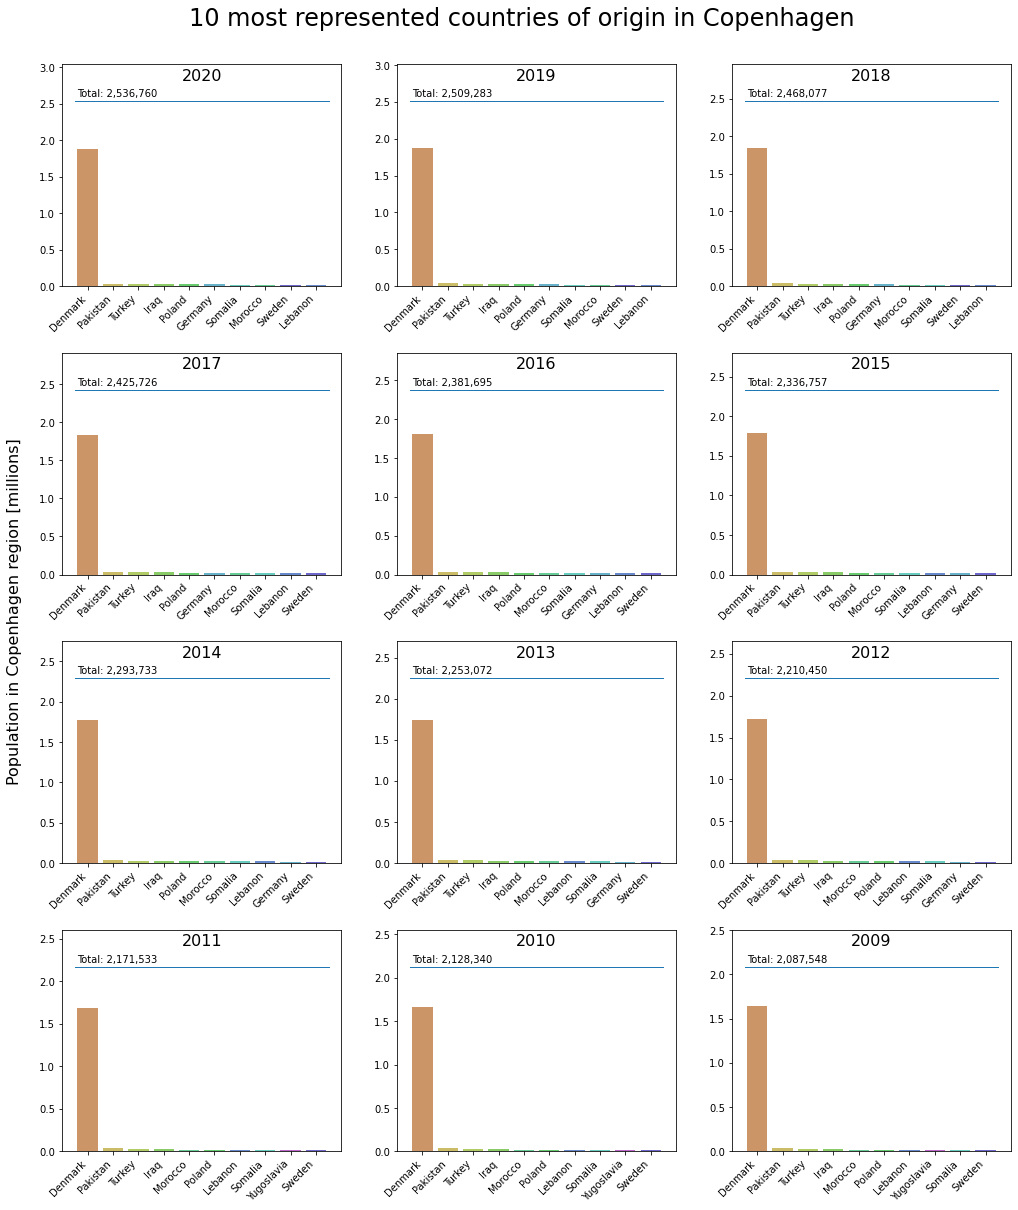

In [80]:
# Get the number of counries.
n_countries = len(countries_sorted_by_number_of_people)

# Get the number of plots.
n_plots = len(years)

# Define the plot grid.
n_plot_columns = 3
n_plot_rows = int(np.ceil(n_plots / n_plot_columns))

# Create a figure for the plots.
figure, all_axes = plt.subplots(
    n_plot_rows, n_plot_columns,
    figsize=(5 * n_plot_columns + 2, 5 * n_plot_rows),
    gridspec_kw={'hspace': 0.3}
)

# Get the handles of the bottom axes'.
bottom_axes = all_axes[-1, :]

# Define colors.
n_countries_to_map = 15
color_palette = sns.color_palette("hls",
                                  n_colors=n_countries_to_map)

# Map the colors to countries.
color_mapping = {country: color
                 for country, color
                 in zip(countries_sorted_by_number_of_people[:n_countries_to_map],
                        color_palette)}

# Plot.
for idx, (year, axes) in enumerate(zip(years, all_axes.ravel()[:n_plots])):

    total = df_country_vs_year.at[year, 'Total']

    sns.barplot(
        data=(
            df_country_vs_year
            .loc[year, ~df_country_vs_year.columns.isin(['Total'])]
            .sort_values(ascending=False)
            .head(10)
            .div(1e6)
            .reset_index()
        ),
        x='Country of origin',
        y=year,
        ax=axes,
        palette=color_mapping)

    # Set the title of the plot.
    axes.set_title(year, y=0.9)
    axes.set_xlabel('')
    axes.set_ylabel('')
    axes.set_ylim([axes.get_ylim()[0], total / 1e6 * 1.2])
    
    draw_threshold(total * 1e-6, axes, title=f'Total: {total:,.0f}')

    # Rotate x tick labels.
    plt.setp(
        axes.get_xticklabels(),
        rotation=45,
        ha='right',
        va='top',
    )

    # Apply the standard formatting.
    format_axes_annotation(axes)

# Annotate the figure.
# figure_x_label(figure, 'Day of week', y_position=0.06)
figure_y_label(figure, 'Population in Copenhagen region [millions]', x_position=0.08)
figure.suptitle('10 most represented countries of origin in Copenhagen', 
                size=24,
                y=0.92)

##### ... by percentage 

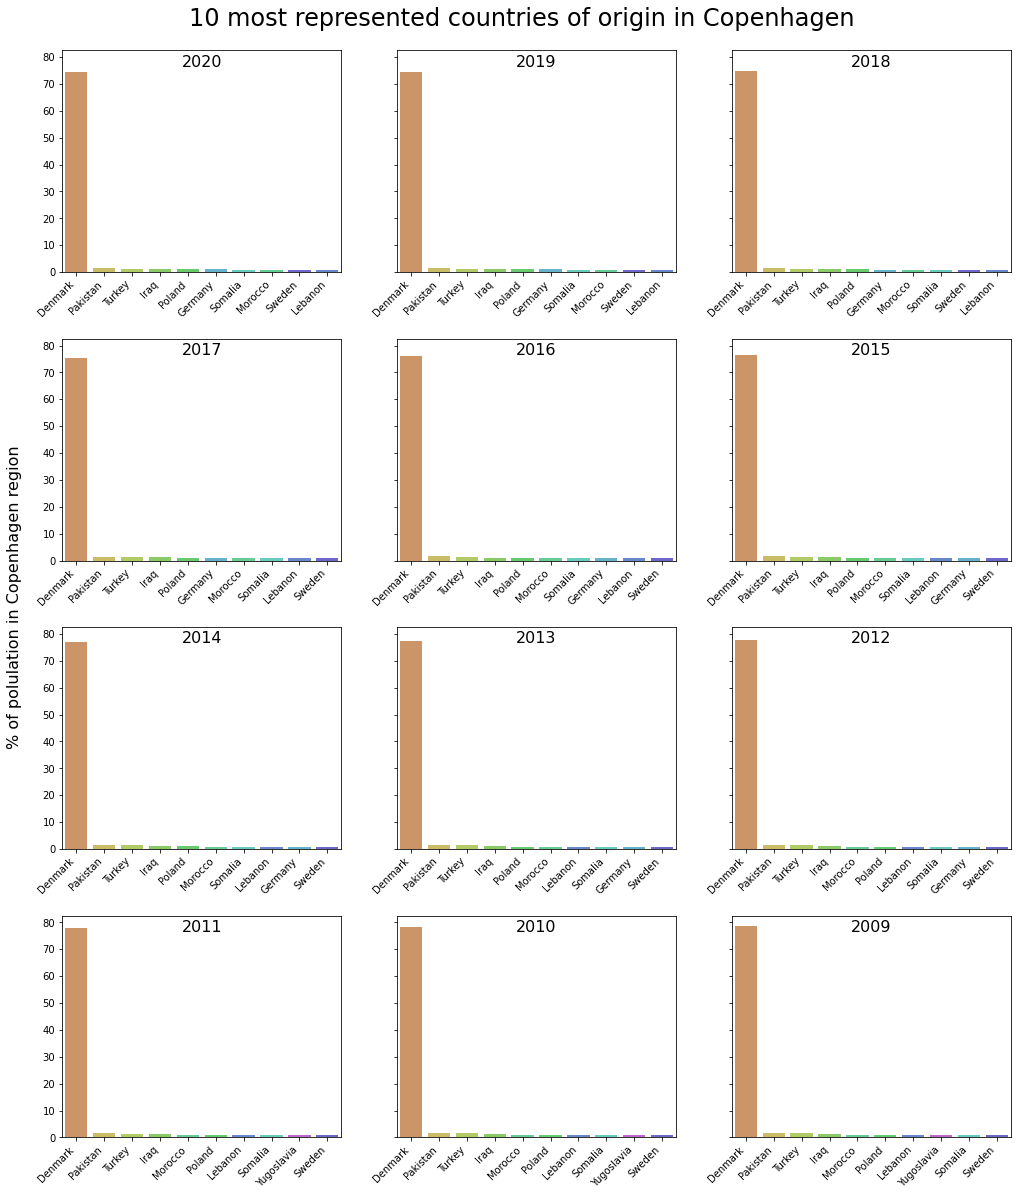

In [90]:
# Get the number of counries.
n_countries = len(countries_sorted_by_number_of_people)

# Get the number of plots.
n_plots = len(years)

# Define the plot grid.
n_plot_columns = 3
n_plot_rows = int(np.ceil(n_plots / n_plot_columns))

# Create a figure for the plots.
figure, all_axes = plt.subplots(
    n_plot_rows, n_plot_columns,
    sharey='all',
    figsize=(5 * n_plot_columns + 2, 5 * n_plot_rows),
    gridspec_kw={'hspace': 0.3}
)

# Get the handles of the bottom axes'.
bottom_axes = all_axes[-1, :]

# Define colors.
n_countries_to_map = 15
color_palette = sns.color_palette("hls",
                                  n_colors=n_countries_to_map)

# Map the colors to countries.
color_mapping = {country: color
                 for country, color
                 in zip(countries_sorted_by_number_of_people[:n_countries_to_map],
                        color_palette)}

# Plot.
for idx, (year, axes) in enumerate(zip(years, all_axes.ravel()[:n_plots])):
    
    # The total number of people in Copenhagen region.
    total = df_country_vs_year.at[year, 'Total']
    
    # Show the barplot.
    sns.barplot(
        data=(
            df_country_vs_year
            .loc[year, ~df_country_vs_year.columns.isin(['Total'])]
            .sort_values(ascending=False)
            .head(10)
            .mul(100 / total)
            .reset_index()
        ),
        x='Country of origin',
        y=year,
        ax=axes,
        palette=color_mapping)

    # Set the title of the plot.
    axes.set_title(year, y=0.9)
    axes.set_xlabel('')
    axes.set_ylabel('')

    # Rotate x tick labels.
    plt.setp(
        axes.get_xticklabels(),
        rotation=45,
        ha='right',
        va='top',
    )

    # Apply the standard formatting.
    format_axes_annotation(axes)

# Annotate the figure.
# figure_x_label(figure, 'Day of week', y_position=0.06)
figure_y_label(figure, r'% of polulation in Copenhagen region', x_position=0.08)
figure.suptitle('10 most represented countries of origin in Copenhagen', 
                size=24,
                y=0.91)

##### Danes vs non-danes 

In [162]:
# Get the number of counries.
n_countries = len(countries_sorted_by_number_of_people)

# Get the number of plots.
n_plots = len(years)

# Define the plot grid.
n_plot_columns = 3
n_plot_rows = int(np.ceil(n_plots / n_plot_columns))

# Create a dataframe with data for danes vs non-danes.
df_danes_vs_non_danes = (
    df_country_vs_year
    .loc[:, 'Denmark']
    .to_frame('Danes')
)

df_danes_vs_non_danes['Non-danes'] = (
    df_country_vs_year
    .loc[:, ~df_country_vs_year.columns.isin(['Total', 'Denmark'])]
    .sum(axis=1)
    .to_frame('Non-danes')
)

df_danes_vs_non_danes[['Pct danes', 'Pct non-danes']] = (
    df_danes_vs_non_danes[['Danes', 'Non-danes']]
    .div(df_danes_vs_non_danes.sum(axis=1), axis=0)
    .mul(100)
)

# Show the dataframe
display(df_danes_vs_non_danes)

,Danes,Non-danes,Pct danes,Pct non-danes
Year,,,,
2009,1641466,446082,78.631294,21.368706
2010,1663336,465004,78.151799,21.848201
2011,1690288,481245,77.838467,22.161533
2012,1719621,490829,77.795064,22.204936
2013,1747493,505579,77.560460,22.439540
2014,1768257,525476,77.090795,22.909205
2015,1788857,547900,76.552975,23.447025
2016,1808614,573081,75.938103,24.061897
2017,1830521,595205,75.462810,24.537190


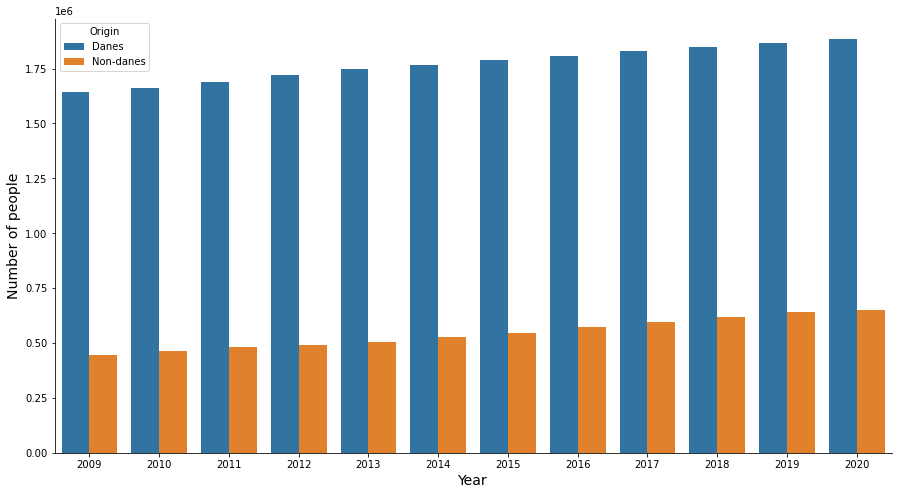

In [163]:
# Create a figure for the plots.
figure, axes = plt.subplots(figsize=(15, 8))

# Create the barplot for each year.
sns.barplot(data=(df_danes_vs_non_danes[['Danes', 'Non-danes']]
                  .reset_index()
                  .melt(id_vars='Year',
                        var_name='Origin',
                        value_name='Number of people')),
            x='Year',
            y='Number of people',
            hue='Origin',
            ax=axes)

format_axes(axes)
format_axes_annotation(axes)

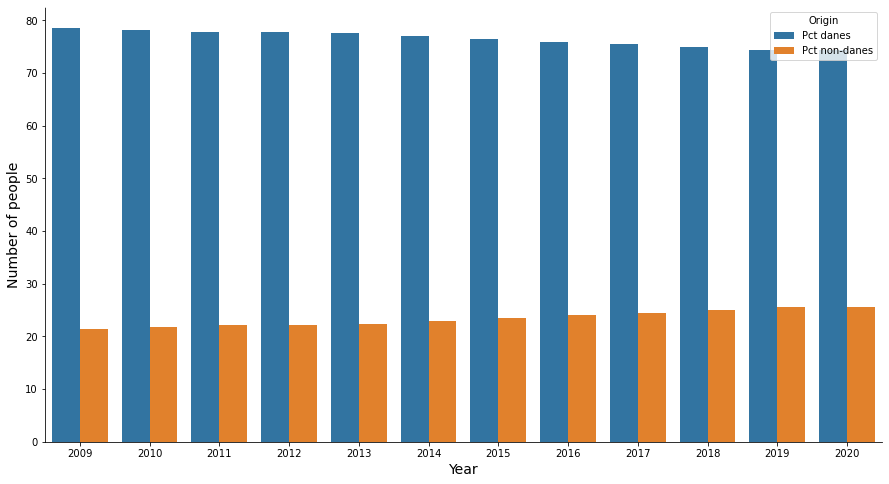

In [164]:
# Create a figure for the plots.
figure, axes = plt.subplots(figsize=(15, 8))

# Create the barplot for each year.
sns.barplot(data=(df_danes_vs_non_danes[['Pct danes', 'Pct non-danes']]
                  .reset_index()
                  .melt(id_vars='Year',
                        var_name='Origin',
                        value_name='Number of people')),
            x='Year',
            y='Number of people',
            hue='Origin',
            ax=axes)

format_axes(axes)
format_axes_annotation(axes)

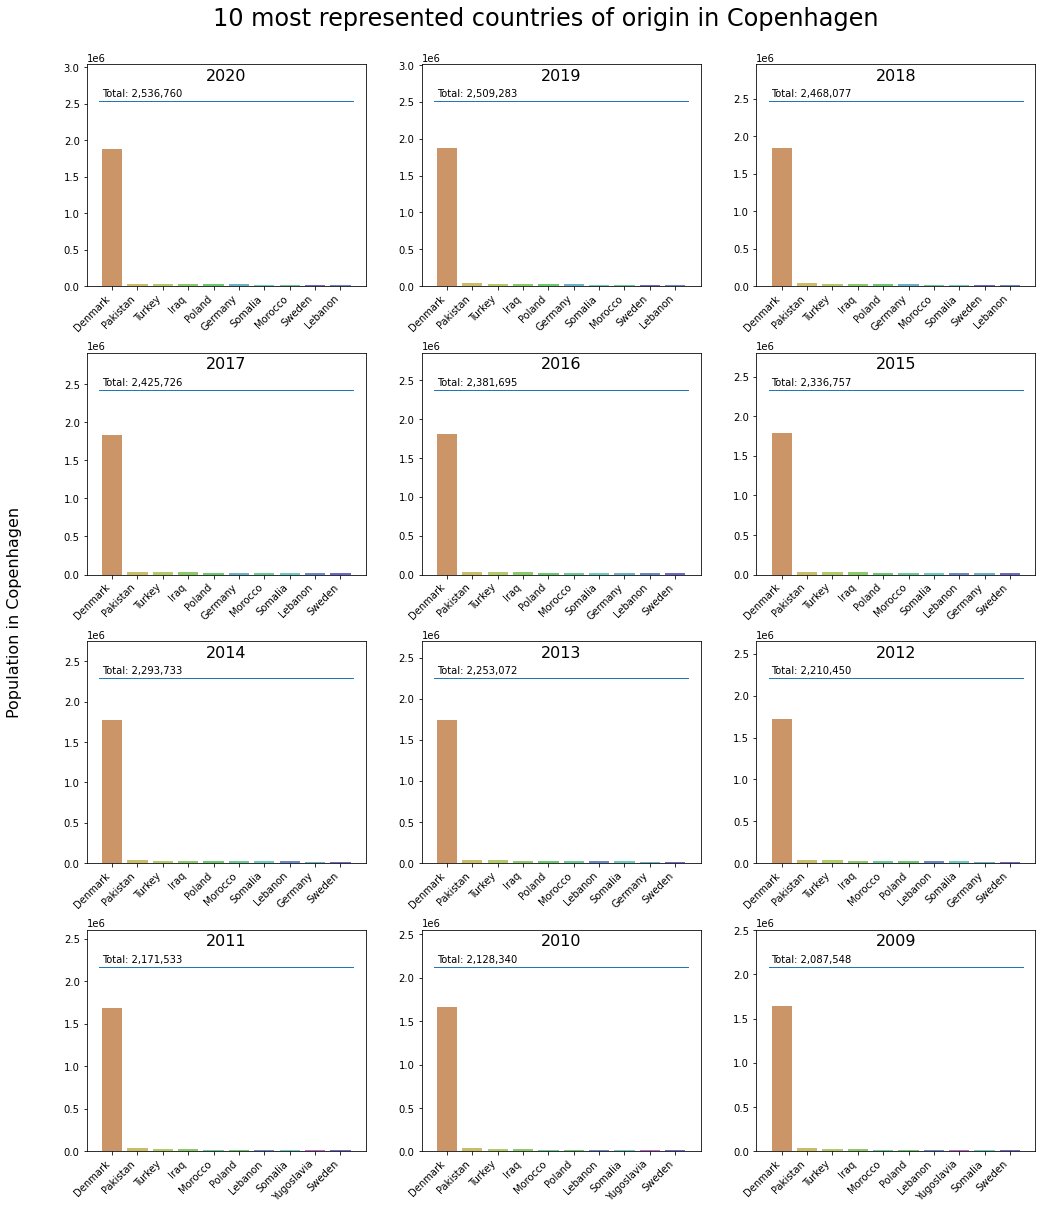

In [84]:
# Create a figure for the plots.
figure, all_axes = plt.subplots(
    n_plot_rows, n_plot_columns,
    figsize=(5 * n_plot_columns + 2, 5 * n_plot_rows),
    gridspec_kw={'hspace': 0.3}
)

# Get the handles of the bottom axes'.
bottom_axes = all_axes[-1, :]

# Define colors.
n_countries_to_map = 15
color_palette = sns.color_palette("hls",
                                  n_colors=n_countries_to_map)

# Map the colors to countries.
color_mapping = {country: color
                 for country, color
                 in zip(countries_sorted_by_number_of_people[:n_countries_to_map],
                        color_palette)}

# Plot.
for idx, (year, axes) in enumerate(zip(years, all_axes.ravel()[:n_plots])):
    
    # The total number of people in Copenhagen region.
    total = df_country_vs_year.at[year, 'Total']
    
    # Create a dataframe with Number
    df_danes_vs_non_danes = df_country_vs_year.loc[year, 'Denmark']  
    df_danes_vs_non_danes['Non-danes'] = (
        df_country_vs_year
        .loc[year,
             ~df_country_vs_year.columns.isin(['Total'])]
        .sum()
    )
        
    # Create the barplot for each year.
    sns.barplot(
        data=(
            df_country_vs_year
            .loc[year, ~df_country_vs_year.columns.isin(['Total'])]
            .sort_values(ascending=False)
            .head(10)
            .reset_index()
        ),
        x='Country of origin',
        y=year,
        ax=axes,
        palette=color_mapping)

    # Set the title of the plot.
    axes.set_title(year, y=0.9)
    axes.set_xlabel('')
    axes.set_ylabel('')
    axes.set_ylim([axes.get_ylim()[0], total * 1.2])
    
    draw_threshold(total, axes, title=f'Total: {total:,.0f}')

    # Rotate x tick labels.
    plt.setp(
        axes.get_xticklabels(),
        rotation=45,
        ha='right',
        va='top',
    )

    # Apply the standard formatting.
    format_axes_annotation(axes)

# Annotate the figure.
# figure_x_label(figure, 'Day of week', y_position=0.06)
figure_y_label(figure, 'Population in Copenhagen', x_position=0.06)
figure.suptitle('10 most represented countries of origin in Copenhagen', 
                size=24,
                y=0.92)

In [89]:
display(
    df_country_vs_year
    .loc[:, ~df_country_vs_year.columns.isin(['Total'])]
    .sum(axis=1)
)

Year
2009    2087548
2010    2128340
2011    2171533
2012    2210450
2013    2253072
2014    2293733
2015    2336757
2016    2381695
2017    2425726
2018    2468077
2019    2509283
2020    2536760
dtype: int64

<hr style="border:2px solid black"> </hr>

# Template



XXX asdfasdfa dasdf    
    
